In [0]:
!pip install wandb -q

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import wandb

In [31]:
!wandb login

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 8c292ca69e334e8a562d4a4c6570fdd3ad29c825
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [1]:
import re
import csv
import string
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence

# from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer

In [2]:
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
def read_dataset():
    input_filename = "data/train_qa.csv"
    dataset = []
    missed = []

    with open(input_filename, encoding='utf-8') as input_file:
        reader = csv.reader(input_file)
        next(reader)
        for row in reader:
            query = row[3]
            if query[-1] == '?':
                query = query[:-1]
            answer = row[4]
            if answer[-3:] == "...":
                answer = answer[:-3]
            if answer[:3] == "...":
                answer = answer[3:]
            if answer[0] == ' ':
                answer = answer[1:]
            if answer[0] in string.punctuation:
                answer = answer[1:]
            if answer[-1] in string.punctuation:
                answer = answer[:-1]
            ans_start = row[2].lower().find(answer.lower())
            ans_len = len(answer)
            if ans_start != -1:
                dataset.append({'paragraph': re.split('(\W)', row[2]),
                                'query': re.split('(\W)', query),
                                'answer': (ans_start, ans_len)})
            else:
                missed.append(answer)
                                
    return dataset, missed


In [5]:
dataset, missed = read_dataset()

In [6]:
print(len(dataset))

50363


In [7]:
print(dataset[0])

{'paragraph': ['Первые', ' ', 'упоминания', ' ', 'о', ' ', 'строении', ' ', 'человеческого', ' ', 'тела', ' ', 'встречаются', ' ', 'в', ' ', 'Древнем', ' ', 'Египте', '.', '', ' ', 'В', ' ', 'XXVII', ' ', 'веке', ' ', 'до', ' ', 'н', '.', '', ' ', 'э', '.', '', ' ', 'египетский', ' ', 'врач', ' ', 'Имхотеп', ' ', 'описал', ' ', 'некоторые', ' ', 'органы', ' ', 'и', ' ', 'их', ' ', 'функции', ',', '', ' ', 'в', ' ', 'частности', ' ', 'головной', ' ', 'мозг', ',', '', ' ', 'деятельность', ' ', 'сердца', ',', '', ' ', 'распространение', ' ', 'крови', ' ', 'по', ' ', 'сосудам', '.', '', ' ', 'В', ' ', 'древнекитайской', ' ', 'книге', ' ', 'Нейцзин', ' ', '', '(', 'XI', '—', 'VII', ' ', 'вв', '.', '', ' ', 'до', ' ', 'н', '.', '', ' ', 'э', '.', '', ')', '', ' ', 'упоминаются', ' ', 'сердце', ',', '', ' ', 'печень', ',', '', ' ', 'лёгкие', ' ', 'и', ' ', 'другие', ' ', 'органы', ' ', 'тела', ' ', 'человека', '.', '', ' ', 'В', ' ', 'индийской', ' ', 'книге', ' ', 'Аюрведа', ' ', '', '(', ''

In [8]:
print(missed)

['Четвёртый альбом Issues (1999) группы Korn также попал на вершину Billboard 200.[118][153] За один месяц он стал трижды платиновым.[154] За первую неделю он разошёлся тиражом 573000 копий,[153] а первый сингл Falling Away from Me достиг 99 позиции в Billboard Hot 100.[155] Немногим раньше, до выхода альбома, Korn появляются в эпизоде Отличная загадка группы Korn о пиратском призраке мультсериала Южный парк, в котором состоялась премьера сингла Falling Away from Me .[156][157] В конце 1990-х и начале 2000-х различные ню-метал-группы, как, например, Korn,[158][159] Limp Bizkit[160][161] и P.O.D.,[162][163] стабильно участвуют в телепередаче Total Request Live на MTV']


In [9]:
stemmer = SnowballStemmer("russian")
# stemmer = Mystem()

In [10]:
word_to_idx = defaultdict(lambda: 0)
separator = 65000
pad_value = 65001

In [11]:
max_p_len = [0]

In [12]:
def my_collate1(row, update_vocab):
    idx = []

    for word in row['paragraph']:
        stemmed = stemmer.stem(word.lower())

        if update_vocab and stemmed not in word_to_idx:
            word_to_idx[stemmed] = len(word_to_idx) + 1
            
        idx.append(word_to_idx[stemmed])
    
    # max_p_len[0] = max(max_p_len[0], len(idx))
    idx.append(separator)

    for word in row['query']:
        stemmed = stemmer.stem(word.lower())

        if update_vocab and stemmed not in word_to_idx:
            word_to_idx[stemmed] = len(word_to_idx) + 1
        
        idx.append(word_to_idx[stemmed])

    return torch.tensor(idx)

In [13]:
def my_collate2(row):
    pos = []
    idx = 0

    for word in row['paragraph']:
        cur_l = len(word)
        pos.append((idx, cur_l))
        idx += cur_l

    return pos

In [14]:
def pad_dataset(dataset, update_vocab):
    num_dataset = [my_collate1(item, update_vocab) for item in tqdm(dataset)]
    return pad_sequence(num_dataset, batch_first=True, padding_value=pad_value)

In [15]:
def pos_dataset(dataset):
    return [my_collate2(item) for item in tqdm(dataset)]

In [16]:
# dataset_padded = pad_dataset(dataset[:5000], True)
dataset_padded = pad_dataset(dataset, True)

In [17]:
print(len(word_to_idx))

59097


In [18]:
# dataset_pos = pos_dataset(dataset[:5000])
dataset_pos = pos_dataset(dataset)

In [19]:
def join_dataset(dataset_padded, dataset_pos, dataset):
    dataset_joined = []

    for sent, pos, row in tqdm(zip(dataset_padded, dataset_pos, dataset)):
        ans_start, ans_len = row['answer']
        y = np.array([0, 0])

        for pos_i in range(len(pos)):
            if pos[pos_i][0] == ans_start:
                y[0] = pos_i
            if pos[pos_i][0] == ans_start + ans_len:
                y[1] = pos_i - 1
            
        dataset_joined.append(np.append(sent.numpy(), y))

    return dataset_joined

In [20]:
dataset_joined = join_dataset(dataset_padded, dataset_pos, dataset)
# print(dataset_joined.shape)

In [21]:
del dataset_padded
del dataset_pos

In [22]:
train, val = train_test_split(dataset_joined, test_size=0.2, random_state=42)

In [23]:
print(train[1])

[  877     2  6150 ... 65001   222   222]


In [24]:
class MyLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, bidirectional, vocab_size, tagset_size):
        super(MyLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                            num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        # self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, tagset_size)
        # self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.word_embeddings(x)
        x, _ = self.lstm(x)
        x = self.fc2(x)
        x = torch.transpose(x, 1, 2)
        x = F.log_softmax(x, dim=2)
        
        return x

In [25]:
def fit(model, train, val, optimizer, loss_function, epoch_cnt, batch_size):
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size)
    train_loss_values = []
    val_loss_values = []
            
    for epoch in tnrange(epoch_cnt, desc='Epoch'):
        for batch_data in train_loader:
            x, y = batch_data[:, :-2].to(device), batch_data[:, -2:].to(device)
            optimizer.zero_grad()
            output = model(x.long())
            y1, y2 = y[:, 0].reshape(-1), y[:, 1].reshape(-1)
            loss1 = loss_function(output[:, 0], y1.long())
            loss2 = loss_function(output[:, 1], y2.long())
            loss = (loss1 + loss2) / 2
            loss.backward()

            train_loss_values.append(loss.item())
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

#             wandb.log({
#                 "Train Loss": loss.item()})

        with torch.no_grad():
            loss_values = []
            for batch_data in val_loader:
                x, y = batch_data[:, :-2].to(device), batch_data[:, -2:].to(device)
                output = model(x.long())
                y1, y2 = y[:, 0].reshape(-1), y[:, 1].reshape(-1)
                loss1 = loss_function(output[:, 0], y1.long())
                loss2 = loss_function(output[:, 1], y2.long())
                loss = (loss1 + loss2) / 2

                loss_values.append(loss.item())
            val_loss_values.append(np.mean(np.array(loss_values)))

#             wandb.log({
#                 "Validation Loss": val_loss_values[-1]})

    return train_loss_values, val_loss_values 


In [26]:
embedding_dim = 64
hidden_dim = 64
num_layers = 1
bidirectional = True
vocab_size = max(pad_value, len(word_to_idx)) + 1
tagset_size = 2
epoch_cnt = 10
batch_size = 64

In [66]:
# del model
torch.cuda.empty_cache()


In [27]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# wandb.init(entity="vadim-farutin", project="HSE-NLP-task3")
# wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
model = MyLSTM(embedding_dim, hidden_dim, num_layers, bidirectional, vocab_size, tagset_size)
model = model.float()
model = model.to(device)

In [28]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [29]:
# wandb.init(entity="vadim-farutin", project="HSE-NLP-task4")
# wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
# wandb.watch(model, log="all")

# # WandB – Config is a variable that holds and saves hyperparameters and inputs
# config = wandb.config          # Initialize config
# config.batch_size = 256          # input batch size for training (default: 64)
# config.test_batch_size = 256    # input batch size for testing (default: 1000)
# config.epochs = 160             # number of epochs to train (default: 10)
# config.lr = 5e-4               # learning rate (default: 0.01)
# config.embedding_dim = 64          # SGD momentum (default: 0.5) 
# config.hidden_dim = 128         # disables CUDA training
# config.num_layers = 1               # random seed (default: 42)
# config.bidirectional = False     # how many batches to wait before logging training status

train_loss_values, val_loss_values =\
    fit(model, train, val, optimizer, loss_function, epoch_cnt, batch_size)

In [30]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / epoch_cnt), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

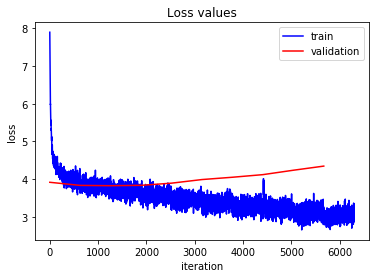

In [31]:
plot_loss_values(train_loss_values, val_loss_values)

In [32]:
def read_input():
    input_filename = "./dataset_281937_1.txt"
    X = []

    with open(input_filename, encoding='utf-8') as input_file:
        reader = csv.reader(input_file, delimiter='\t')
        next(reader)
        for row in reader:
            query = row[3]
            if query[-1] == '?':
                query = query[:-1]
            X.append({'paragraph': re.split('(\W)', row[2]),
                      'query': re.split('(\W)', query),
                      'query_id': row[1]})

    return X


In [33]:
test = read_input()
test_padded = pad_dataset(test, False)
test_pos = pos_dataset(test)

In [34]:
print(test_padded.shape)

torch.Size([1000, 743])


In [0]:
new_words = 0
cnt_words = 0

for sent in test:
    for word in sent:
        stemmed = stemmer.stem(word.lower())
        cnt_words += 1

        if stemmed not in word_to_idx:
            new_words += 1

print(new_words)
print(cnt_words)

355
19632


In [35]:
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(test_padded, batch_size=batch_size)
    ans = None
    
    for batch_data in test_loader:
        x = batch_data.to(device)
        output = model(x.long())
        _, ansx = output.max(dim=2)
        ansx = ansx.cpu().numpy()
        if ans is None:
            ans = ansx
        else:
            ans = np.append(ans, ansx, axis=0)

In [36]:
print(ans[0])

[178  56]


In [37]:
output_filename = "./output.txt"

with open(output_filename, "w", encoding="utf-8") as output_file:
    for tags, row in zip(ans, test):
        start, end = tags
        if start > end:
            start, end = end, start
        if end >= len(row['paragraph']):
            start, end = 0, 0
        output_file.write("%s\t%s\n" % (row['query_id'], "".join(row['paragraph'][start:end + 1])))
